<a href="https://colab.research.google.com/github/BrunoMoss/BI-Master/blob/main/Trabalho_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalação de bibliotecas

In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.7 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math
import requests
import json
plt.style.use("dark_background")


## Carregamento de dados

In [3]:
# Acessa os 100 mais negociados ETF's no mercado americano

url = "https://www.etfcentral.com/search-api/search_v2/_/ju=232/nyseTicker,label,exposure_description,nyseTraded,usd_flow1m,usd_perf1m,shareVol1m,usd_aum,expense_ratio,ttmDividendYield/default/0/100"

payload = {}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)

data = json.loads(response.text)

tickers = [item['nyseTicker'] for item in data['results']['docs']]

In [4]:
# Seleciona os 50 mais negociados
tickers = tickers[:50]

In [ ]:
# prompt: salvar a lista tickers em um csv no meu  drive
from google.colab import drive
drive.mount('/content/drive')

# Salva a lista de tickers em um arquivo CSV no Google Drive
file_path = '/content/drive/My Drive/tickers.csv'  # Substitua pelo caminho desejado no seu Google Drive
pd.DataFrame({'Tickers': tickers}).to_csv(file_path, index=False)

## Estudo de caso

In [5]:
# Essa função retorna em um DataFrame os preços de fechamento ajustados

df = yf.download(tickers,
              start = '2024-01-01', end = '2024-08-01')['Adj Close']


# Função do pandas para calcular os retornos diários
# dropna é para remover a primeira linha que vai ser nula
df.bfill(inplace=True)
df = df.pct_change().dropna()

[**********************92%*******************    ]  46 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  50 of 50 completed


In [6]:
df.head()

Ticker,AGG,BND,BNDX,DIA,EFA,GLD,IBIT,IEFA,IEMG,IJH,...,VTV,VUG,VV,VWO,VXUS,VYM,XLE,XLF,XLK,XLV
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03 00:00:00+00:00,0.000506,0.000819,0.003050,-0.007637,-0.007516,-0.008337,0.0,-0.008192,-0.004805,-0.022624,...,-0.006249,-0.010112,-0.008107,-0.002954,-0.006283,-0.006051,0.016285,-0.008474,-0.010190,-0.001657
2024-01-04 00:00:00+00:00,-0.004047,-0.004502,-0.006082,0.000882,0.002299,0.001005,0.0,0.002608,-0.002816,-0.001815,...,-0.001003,-0.004760,-0.003297,-0.001728,0.000527,-0.000895,-0.017534,0.004006,-0.007330,0.004980
2024-01-05 00:00:00+00:00,-0.002337,-0.003015,-0.002447,0.000267,0.000674,0.000158,0.0,0.000144,0.002219,0.003636,...,0.001942,0.001129,0.001864,0.001484,0.000702,0.002509,0.000827,0.004257,-0.000271,-0.000862
2024-01-08 00:00:00+00:00,0.003768,0.004399,0.001840,0.005872,0.010651,-0.007816,0.0,0.010983,0.002818,0.012532,...,0.006684,0.021102,0.014092,0.001729,0.008244,0.005632,-0.011573,0.006358,0.025092,0.008841
2024-01-09 00:00:00+00:00,-0.000203,-0.000137,-0.000816,-0.004405,-0.008938,0.000319,0.0,-0.008290,-0.013850,-0.006426,...,-0.005577,0.002177,-0.001926,-0.011588,-0.009742,-0.006400,-0.016010,-0.006317,0.001589,-0.000143


### Classe com otimizador

In [7]:
class OtimizadorPortfolio:

    def __init__(self, alpha, days,lbda,nr_assets,vl_var_min,vl_var_max,min_weight):
         """
        Inicializa uma instância da classe OtimizadorPortfolio.

        Args:
            alpha (float): Nível de significância do Var paramétrico
            days (int): Base de cálculo das medidas.
            lbda (float): Lambda, fator de decaimento para EWMA.
            nr_assets (int): Número de ativos no portfólio.
            vl_var_min (float): Var mínimo do portfólio.
            vl_var_max (float): Var máximo do portfólio.
            min_weight (float): Peso mínimo dos ativos no portfólio.

        """
        self.alpha = alpha
        self.days = days
        self.lbda = lbda
        self.alpha = alpha
        self.nr_assets = nr_assets
        self.vl_var_min = vl_var_min
        self.vl_var_max = vl_var_max
        self.min_weight = min_weight
        self.df_rets = None

    def set_returns(self, df_rets):
        self.df_rets = df_rets

    def __EWMA_Volatility(self,rets):
       """
        Calcula a volatilidade EWMA de uma série.

        Args:
            rets (DataFrame): Retornos diários.
        Returns:
            float: Volatilidade EWMA.
        """

      sq_rets_sp500 = (rets**2).values
      EWMA_var = np.zeros(len(sq_rets_sp500))

      for r in range(1, len(sq_rets_sp500)):
          EWMA_var[r] = (1-self.lbda)*sq_rets_sp500[r] + self.lbda*EWMA_var[r-1]

      EWMA_vol = np.sqrt(EWMA_var)
      return EWMA_vol[-1]

    def calc_port_vol(self,df_rets,weights,days,ewma=True):
       """
        Calcula a volatilidade de um portfolio.

        Args:
            df_rets(DataFrame): Retornos diários dos ativos que compõem o portfolio.
            weights (list): Pesos dos ativos no portfólio.
            days (int): Base de cálculo das medidas.
            ewma (bool): Indica se o EWMA deve ser utilizado.
        Returns:
            float: Volatilidade do portfolio.
        """
      if ewma:
        ewma_vols = np.array([self.__EWMA_Volatility(df_rets[c]) for c in df_rets.columns])
        matriz_correl = np.corrcoef(df_rets.T.values)
        cov = np.outer(ewma_vols, ewma_vols) * matriz_correl
      else:
        cov = df_rets.cov()
      # Calcula a volatilidade do portfolio
      portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
      return portfolio_vol

    def calc_portfolio_perf_VaR(self,weights,df_rets,days):
        """
        Calcula o retorno, volatilidade e VaR de um portfolio.

        Args:
            weights (list): Pesos dos ativos no portfólio.
            df_rets(DataFrame): Retornos diários dos ativos que compõem o portfolio.
            days (int): Base de cálculo das medidas.
        Returns:
            float: Retorno do portfolio.
            float: Volatilidade do portfolio.
            float: VaR do portfolio.
        """
        weights = np.array(weights)
        mean_returns = df_rets.mean()
        portfolio_return = np.sum(mean_returns * weights) * days
        portfolio_vol = self.calc_port_vol(df_rets,weights,days)
        portfolio_var = abs(portfolio_return - (portfolio_vol * norm.ppf(1 - self.alpha)))
        return portfolio_return, portfolio_vol, portfolio_var

    def __evaluate_function(self,individual):
      """
      Função de que será maximizada
      """

      weights = np.array(individual)
      weights = weights / np.sum(weights)
      ret =  self.calc_portfolio_perf_VaR(weights,self.df_rets,self.days)[0]
      return ret,

    def __create_individuals(self,icls, random_function):
      """
      Função para criar os indivíduos
      """
      i = 0
      cromossomo = list()
      for _ in range(len(self.df_rets.columns)):
        cromossomo.append(random_function())
      return icls(cromossomo)

    def __count_not_equal_zero(self,arr):
      """
      Funções para a restrição do número de ativos no portfólio
      """
      # Arredonda cada elemento do array para a quarta casa decimal
      rounded_arr = [round(num, 4) for num in arr]

      # Conta quantos elementos arredondados são iguais a zero
      zero_count = sum(1 for num in rounded_arr if num == 0)

      # Retorna número de items diferente de zero
      return len(arr) - zero_count

    def __count_items_in_range(self,array, k):
      """
      Funções para a restrição do peso dos ativos no portfólio
      """
      return sum(1 for item in array if 0 < item < k)

    def __penalizeVar(self,x, lower_bound, upper_bound):
      """
      Função de penalização para a restrição do VaR
      """
      if x < lower_bound:
          return lower_bound - x
      elif x > upper_bound:
          return x - upper_bound
      else:
          return 0

    def __feasible_func(self,individual):
      """
      Função que verifica se o indivíduo obedece as restrições de intervalo de VaR, número de ativos e peso mínimo.
      """
      weights = np.array(individual)
      weights = weights / np.sum(weights)
      var =  self.calc_portfolio_perf_VaR(weights,self.df_rets,self.days)[2]
      return self.__count_not_equal_zero(individual) == self.nr_assets and self.__count_items_in_range(weights,self.min_weight) == 0 and (self.vl_var_min < var < self.vl_var_max)

    def ___distance(self,individual):
      """
      Função distância
      """
      weights = np.array(individual)
      weights = weights / np.sum(weights)
      penalty_weights = self.__count_items_in_range(weights,self.min_weight)
      penalty_assets = abs(self.__count_not_equal_zero(weights) -self.nr_assets)
      var = self.calc_portfolio_perf_VaR(weights,self.df_rets,self.days)[2]
      penalty_var = self.__penalizeVar(var,self.vl_var_min,self.vl_var_max)
      return var + (penalty_weights + penalty_assets + penalty_var)*10

    def run_optimization(self,population,nr_ger):
      """
      Função para rodar a otimização
      """
      creator.create("FitnessMax", base.Fitness, weights=(1.0,))
      creator.create("Individual", list, fitness=creator.FitnessMax)

      toolbox = base.Toolbox()
      # Definir o gerador de numeros aleatórios de numeros inteiros entre o intervalo (0 e 1000000)
      toolbox.register("random_int", random.randint, 0, 1000000)
      # Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
      toolbox.register("individual", self.__create_individuals, creator.Individual, toolbox.random_int)
      # Registro do individuo na população
      toolbox.register("population", tools.initRepeat, list, toolbox.individual)
      # Registro do nome da função objetivo
      toolbox.register("evaluate",self.__evaluate_function)
      # Registro da função de penalidade caso o individuo não obedeça as restrições
      toolbox.decorate("evaluate", tools.DeltaPenalty(self.__feasible_func, 0, self.___distance))
      # Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
      toolbox.register("mate", tools.cxTwoPoint)
      # Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
      toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
      # Registro de qual o tipo do método de seleção que será utilizado
      toolbox.register("select", tools.selTournament, tournsize=10)

      pop = toolbox.population(n=population)                   # inicialização da pop
      hof = tools.HallOfFame(1)                                # melhor indivíduo
      stats = tools.Statistics(lambda ind: ind.fitness.values) # estatísticas
      stats.register("avg", np.mean)
      stats.register("std", np.std)
      stats.register("min", np.min)
      stats.register("max", np.max)
      hof.clear()

      pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.85, mutpb=0.5, ngen=nr_ger, stats=stats, halloffame=hof, verbose=True)

      return hof


### Definição de parâmetros do modelo
O portfolio será criado com base nos dados dos 50 ativos mais negociados.
Ele deverá ter um VaR mínimo de 1.1% e um VaR máximo de 1.2%.
Deverá ser composto por no máximo 5 ativos e cada ativo deverá ter um peso mínimo de 5%.

In [8]:
alpha = 0.95
days = 1
lbda = 0.94
nr_assets = 5
vl_var_min = 0.01  # 1.1%
vl_var_max = 0.012 # 1.2%
min_weight = 0.05  # 5%
optm = OtimizadorPortfolio(alpha,days,lbda,nr_assets,vl_var_min,vl_var_max,min_weight)

In [9]:
optm.set_returns(df)
hof = optm.run_optimization(2000,30)

gen	nevals	avg     	std    	min     	max     
0  	2000  	-949.254	2.85726	-950.038	-920.015
1  	1881  	-772.327	177.629	-950.031	-360.017
2  	1876  	-433.449	107.676	-880.02 	-140.011
3  	1850  	-260.532	54.6792	-510.011	-110.017
4  	1871  	-188.635	37.1098	-340.029	-80.012 
5  	1815  	-158.305	40.7698	-340.017	-50.0214
6  	1834  	-139.371	47.5865	-300.029	-30.018 
7  	1876  	-123.997	55.0101	-380.118	-20.0115
8  	1839  	-108.977	59.1586	-340.065	-10.0104
9  	1844  	-97.3119	64.0526	-390.023	0.00074298
10 	1839  	-93.9132	69.016 	-260.037	0.000767328
11 	1845  	-83.8075	71.8598	-260.027	0.000884921
12 	1843  	-79.7539	75.1569	-280.036	0.000884921
13 	1865  	-78.731 	75.7408	-250.073	0.000902065
14 	1843  	-77.0681	75.8672	-390.056	0.000902065
15 	1866  	-77.2218	75.8857	-260.034	0.000912967
16 	1841  	-75.4767	76.2709	-250.034	0.00104053 
17 	1841  	-77.8879	77.9908	-260.144	0.00104053 
18 	1848  	-76.3179	77.426 	-250.049	0.00104053 
19 	1844  	-78.1233	77.4089	-260.089	0.00104053 
20

In [10]:
print("Melhor Indivíduo:")
weights = np.array(hof[0])/np.sum(hof[0])
print(weights)

Melhor Indivíduo:
[0.         0.         0.         0.         0.         0.29406323
 0.10943399 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.28968942 0.         0.         0.
 0.         0.         0.         0.22218607 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0846273  0.         0.         0.         0.         0.
 0.         0.        ]


In [11]:
best_result = optm.calc_portfolio_perf_VaR(weights,df,1)
print(f"Return: {best_result[0]:%}")
print(f"Vol: {best_result[1]:%}")
print(f"VaR: {best_result[2]:%}")

Return: 0.104053%
Vol: 0.655301%
VaR: 1.181927%


In [12]:
sum(weights)

1.0

### Simulação de 1000 portfólios com pesos aleatórios

In [13]:
import pandas as pd
def simulate_random_portfolios_VaR(num_portfolios,df, alpha, days,nr_assets):
    results_matrix = np.zeros((len(df.columns)+3, num_portfolios))
    for i in range(num_portfolios):
        non_zeros = np.random.random(nr_assets)
        zeros = np.zeros(len(df.columns)-nr_assets)
           # Combinar os dois arrays
        combined_array = np.concatenate((zeros, non_zeros))
        # Embaralhar o array combinado
        np.random.shuffle(combined_array)
        weights =combined_array/ np.sum(combined_array)
        portfolio_return, portfolio_std, portfolio_VaR = optm.calc_portfolio_perf_VaR(weights, df, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])

    return results_df

In [14]:
num_portfolios = 1000
results_frame = simulate_random_portfolios_VaR(num_portfolios, df, alpha, days,nr_assets)
best_result = optm.calc_portfolio_perf_VaR(weights,df,days)

No gráfico abaixo podemos verificar o ponto azul que é o ponto de menor valor Retono x Var gerado a partir dos pesos aleatórios. O ponto em vermelho foi gerado através do modelo de otimização e mostra a maximização do retorno para uma faixa de VaR atribuída.

<ipython-input-15-12874380f0c5>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=100)


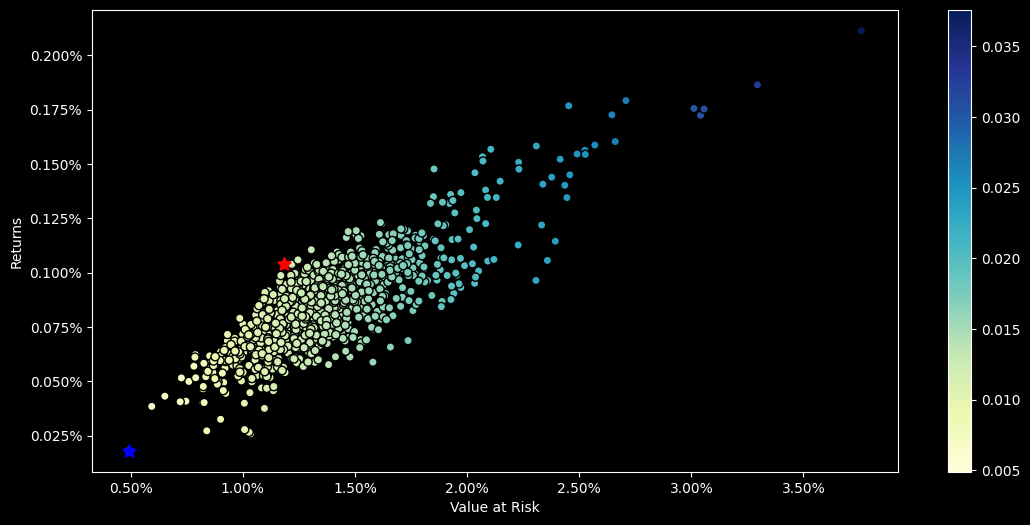

In [15]:
import matplotlib.ticker as mtick
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
fig, ax = plt.subplots(figsize=(13,6))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

# Formatar o eixo x como percentual
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# Formatar o eixo y como percentual
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#plot blue star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=100)
plt.scatter(best_result[2],best_result[0],marker=(5,1,0),color='r',s=100)
plt.show()

### Definição de um benchark

Foi definido um benchmark (S&P 100) para comparação do desempenho do portfolio

In [16]:
bench = '^OEX'

In [17]:
df_bench = yf.download(bench,
               start = '2024-01-01', end = '2024-08-01')['Adj Close']
df_bench = df_bench.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### Comparação dos resultados do portfolio gerado com o benchmark

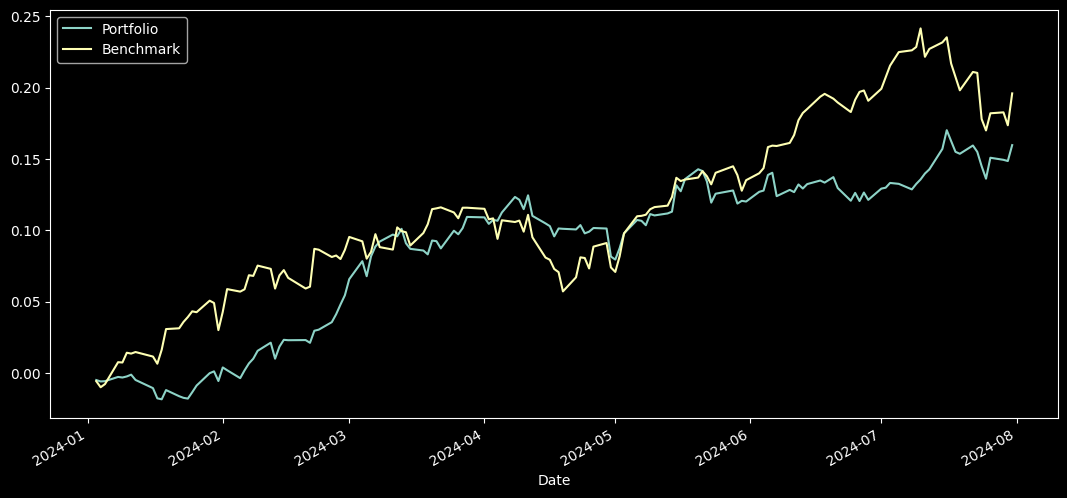

In [18]:
# Calculate the weighted stock returns
WeightedReturns = df*weights

# Calculate the weighted stock returns
portfolioReturns= WeightedReturns.sum(axis=1)

# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+portfolioReturns).cumprod()-1)
CumulativeReturnsBench = ((1+df_bench).cumprod()-1)
df_perf_compare = pd.DataFrame({'Portfolio':CumulativeReturns,'Benchmark':CumulativeReturnsBench.squeeze()})
df_perf_compare.plot(figsize=(13,6))
plt.show()

In [39]:
best_result = optm.calc_portfolio_perf_VaR([1.0],df_bench,1)
print(f"Return: {best_result[0]:%}")
print(f"Vol Ewma: {best_result[1]:%}")
print(f"VaR: {best_result[2]:%}")
print(f"Sharpe Ratio: {best_result[0]/optm.calc_port_vol(df_bench,np.array([1.0]),1,False):%}")

Return: 0.126576%
Vol Ewma: 1.011949%
VaR: 1.791084%
Sharpe Ratio: 15.970612%


In [40]:
best_result = optm.calc_portfolio_perf_VaR(weights,df,1)
print(f"Return: {best_result[0]:%}")
print(f"Vol Ewma: {best_result[1]:%}")
print(f"VaR: {best_result[2]:%}")
print(f"Sharpe Ratio: {best_result[0]/optm.calc_port_vol(df,weights,1,ewma=False):%}")

Return: 0.104053%
Vol Ewma: 0.655301%
VaR: 1.181927%
Sharpe Ratio: 17.158480%


O sharpe gerado pelo portifolio foi maior do que o gerado pelo benckmark

## Estudo para implementação de ferramenta de geração de portfolios

In [42]:
df_test = yf.download(tickers,
              start = '2023-11-01', end = '2024-11-01')['Adj Close']


# Função do pandas para calcular os retornos diários
# dropna é para remover a primeira linha que vai ser nula
df_test.bfill(inplace=True)
df_test = df_test.pct_change().dropna()


[*****                 10%                       ]  5 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********             18%                       ]  9 of 50 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
[*********************100%***********************]  50 of 50 completed


In [43]:
df_bench_test = yf.download(bench,
              start = '2023-11-01', end = '2024-11-01')['Adj Close']


# Função do pandas para calcular os retornos diários
# dropna é para remover a primeira linha que vai ser nula
df_bench_test.bfill(inplace=True)
df_bench_test = df_bench_test.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [87]:
# Função para dado uma janela temporal de x meses gerar uma lista com uma janela de n meses consecutivos e m meses posteriores a esses n meses.
# Cada item da lista de retorno representa uma nova janela ao avançar mês a mês nos x meses.
def create_subseries(df,n_train,m_test):
  """
  Função para dado uma janela temporal de x meses gerar uma lista com uma janela de n meses consecutivos e m meses posteriores a esses n meses.
  Args:
      df(DataFrame): dataframe com  série que será utilizada para gerarmos os dados de treino e teste.
      n_train(int): número de meses que serão utilizados para gerar os dados de treino.
      m_test(int): número de meses que serão utilizados para gerar os dados de teste.
  Returns:
      list: lista com os dados de treino e teste.

  """

  if isinstance(df, pd.Series):
    df = df.to_frame()

  # Extrair o mês e o ano
  df['ano_mes'] = df.index.to_period('M')

  # Agrupar por ano e mês
  grouped = df.groupby('ano_mes')

  # Criar a lista de subseries
  subseries = [group.drop('ano_mes',axis=1) for _, group in grouped]

  splited_subseries = []
  for i in range(len(subseries)-n_train-m_test):
    splited_subseries.append ((pd.concat(subseries[i:n_train+i]),pd.concat(subseries[i+n_train:i+n_train+m_test])))

  return splited_subseries


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Será gerado uma amostra com 6 meses para treino e geração dos pesos dos portfolios e 1 mês para o teste desses pesos contra o benchmark.
A cada ciclo os pesos são regerados com base nos dados dos últimos 6 meses e confrontados contra o resultado do benckmark do próximo mês.

In [88]:
data_test = create_subseries(df_test,6,1)

<ipython-input-87-1422896dcf1d>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['ano_mes'] = df.index.to_period('M')


In [89]:
data_bench_test = create_subseries(df_bench_test,6,1)

<ipython-input-87-1422896dcf1d>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['ano_mes'] = df.index.to_period('M')


### Treinamento e geração dos pesos dos portfolios

A cada ciclo treino são armazenados os pesos gerados junto com algumas métricas referente a comparação dos resultados dos porfolios e do benchmark para os dados de treino.

In [91]:
import warnings
warnings.filterwarnings(action='once')
df_results = pd.DataFrame(columns=['period','weights','vol_port','vol_bench','rent_port','rent_bench','sharp_port','sharp_bench'])
for i in range(len(data_test)):
  print(f'Iteração nr {i}')
  optm.set_returns(data_test[i][0])
  hof = optm.run_optimization(1000,15)
  w = np.array(hof[0])/np.sum(hof[0])
  best_result = optm.calc_portfolio_perf_VaR(w,data_test[i][0],1)
  sharpe_port = best_result[0]/optm.calc_port_vol(data_test[i][0],w,1,ewma=False)
  best_result_bench = optm.calc_portfolio_perf_VaR([1.0],data_bench_test[i][0],1)
  sharpe_bench = best_result_bench[0]/optm.calc_port_vol(data_bench_test[i][0],np.array([1.0]),1,False)
  df_results.loc[i] = [i,w,best_result[1],best_result_bench[1],best_result[0],best_result_bench[0],sharpe_port,sharpe_bench]

Iteração nr 0


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min    	max     
0  	1000  	-949.317	2.77679	-950.03	-920.023
1  	933   	-767.805	179.443	-950.022	-350.011
2  	940   	-428.857	103.517	-730.011	-130.021
3  	925   	-259.881	54.6344	-440.028	-120.018
4  	908   	-187.226	37.6989	-300.012	-90.0194
5  	923   	-159.51 	41.788 	-300.022	-50.0243
6  	933   	-138.283	47.9784	-280.065	-30.0118
7  	946   	-124.683	54.2034	-320.011	-10.0116
8  	934   	-109.562	62.3594	-390.029	0.00106876
9  	941   	-102.165	65.9718	-270.021	-0.0240966
10 	931   	-89.432 	70.7806	-270.044	0.00114573
11 	917   	-84.3992	72.6588	-270.025	0.00117055
12 	936   	-83.3175	75.763 	-250.031	0.00117055
13 	912   	-80.6742	76.8534	-240.042	0.00121686
14 	940   	-79.7525	76.288 	-240.011	0.00121686
15 	939   	-77.652 	77.1208	-270.044	0.00121686
Iteração nr 1


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1000  	-949.191	3.02117	-950.013	-920.011
1  	918   	-773.301	178.215	-950.012	-310.011
2  	936   	-427.132	104.451	-710.011	-200.012
3  	913   	-257.313	52.4843	-430.01 	-120.01 
4  	926   	-186.606	37.1865	-320.015	-90.0105
5  	922   	-156.319	38.0936	-280.072	-50.0134
6  	915   	-142.139	46.5064	-280.045	-40.0226
7  	936   	-127.989	53.9084	-280.018	-30.0117
8  	920   	-113.169	57.6633	-270.011	-10.012 
9  	932   	-108.841	66.0602	-390.012	0.000972955
10 	910   	-95.603 	68.3328	-260.03 	0.00107333 
11 	941   	-88.5704	70.5969	-240.036	0.00118962 
12 	935   	-86.6386	73.6466	-260.029	0.0011855  
13 	932   	-82.3466	75.3634	-370.011	0.00124389 
14 	924   	-75.3756	74.8526	-260.024	0.00124389 
15 	927   	-82.6253	76.8845	-240.063	0.00124389 
Iteração nr 2


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1000  	-949.218	3.09202	-950.026	-910.012
1  	914   	-770.026	182.882	-950.022	-350.014
2  	916   	-429.196	105.355	-900.013	-180.023
3  	903   	-256.697	53.7985	-420.018	-110.011
4  	937   	-185.899	37.799 	-360.013	-80.0102
5  	903   	-155.89 	40.5018	-280.011	-50.0111
6  	929   	-141.49 	48.7595	-280.018	-30.0137
7  	945   	-129.438	56.7873	-420.444	-20.0103
8  	921   	-116.458	59.9427	-300.011	-20.0103
9  	921   	-109.478	63.9128	-260.055	-10.01  
10 	921   	-96.6867	67.9506	-260.02 	0.000691817
11 	909   	-87.5769	71.5899	-250.024	0.00105329 
12 	922   	-84.9767	74.0724	-270.011	0.00116779 
13 	910   	-79.6926	74.9286	-290.028	0.001185   
14 	915   	-76.2407	75.527 	-250.049	0.00124263 
15 	929   	-76.7201	76.1685	-260.085	0.00124263 
Iteração nr 3


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std    	min     	max     
0  	1000  	-949.38	2.56703	-950.038	-930.021
1  	921   	-775.667	178.563	-950.03 	-390.016
2  	926   	-429.029	106.87 	-710.012	-190.015
3  	899   	-262.483	53.4175	-460.048	-100.011
4  	916   	-192.765	37.1101	-320.051	-90.0109
5  	926   	-163.239	40.6551	-320.092	-70.0103
6  	920   	-142.561	47.3791	-410.016	-40.0142
7  	934   	-131.358	54.3092	-430.024	-10.0364
8  	909   	-116.509	58.5214	-280.042	-0.0210358
9  	930   	-105.411	63.0835	-430.025	-0.0210358
10 	942   	-97.7287	69.0184	-370.029	0.000735937
11 	907   	-92.0131	71.3794	-410.012	0.000927872
12 	935   	-95.5614	75.5471	-430.042	0.000927872
13 	925   	-91.3906	79.9774	-410.019	0.000927872
14 	926   	-81.5378	77.1744	-390.029	0.000992072
15 	921   	-82.1759	77.1082	-410.012	0.000993439
Iteração nr 4


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std    	min     	max     
0  	1000  	-949.366	2.57905	-950.055	-930.034
1  	908   	-783.941	176.832	-950.043	-400.043
2  	922   	-437.642	104.82 	-720.048	-170.014
3  	928   	-263.744	55.8255	-470.032	-120.011
4  	931   	-189.864	37.3453	-320.038	-90.0111
5  	912   	-160.234	38.7864	-290.025	-70.0202
6  	932   	-146.786	47.7191	-370.034	-30.0855
7  	922   	-127.858	52.8032	-430.029	-30.0172
8  	943   	-120.122	59.6524	-270.068	-20.0285
9  	924   	-100.653	64.8477	-390.037	-0.107654
10 	934   	-95.5914	68.1045	-260.153	-0.0187192
11 	928   	-86.0312	69.9189	-250.062	-0.0142527
12 	923   	-84.3803	73.3117	-270.033	0.000676604
13 	927   	-83.4804	75.4131	-290.041	0.000782463
14 	936   	-83.6973	76.218 	-240.067	0.000791384
15 	917   	-77.5901	76.2392	-250.098	0.000792988


Comparação da rentabilidade acumulada do portfolio x benchmarck nos períodos de treino.

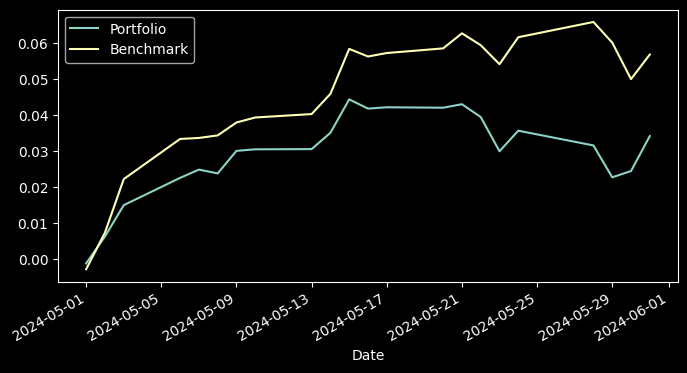

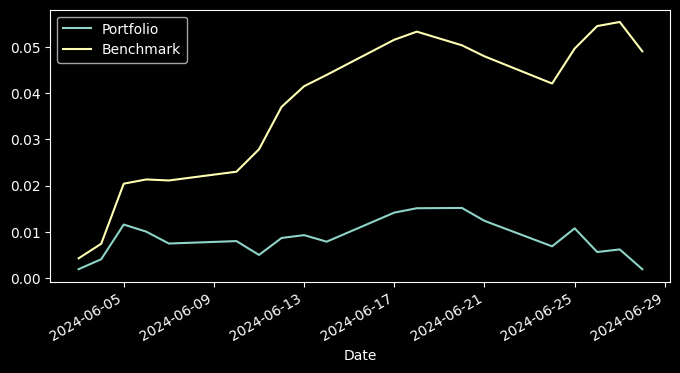

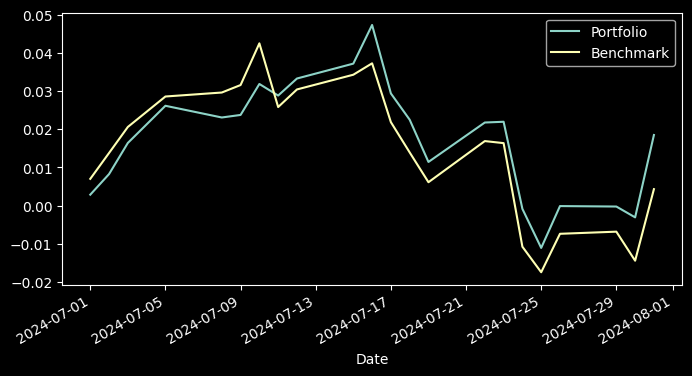

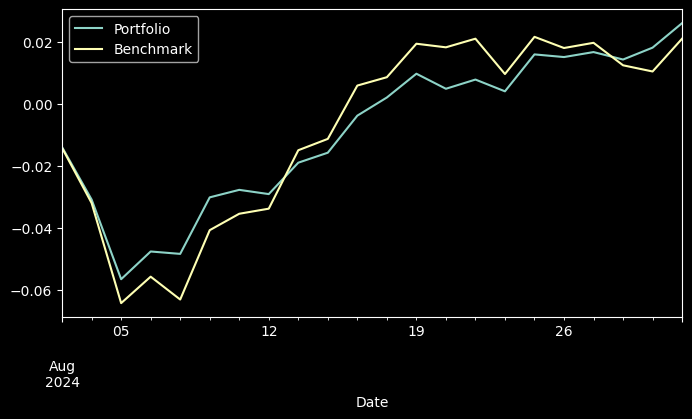

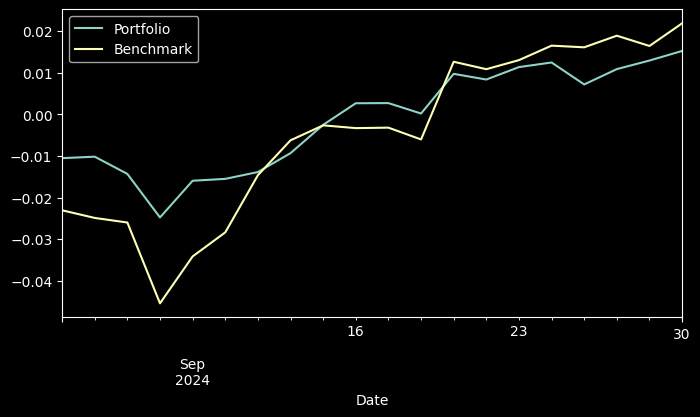

In [92]:
for i in range(len(data_test)):
  # Calculate the weighted stock returns
  WeightedReturns = data_test[i][1]*df_results.loc[i,'weights']
  # Calculate the weighted stock returns
  portfolioReturns= WeightedReturns.sum(axis=1)
  # Plot the cumulative portfolio returns over time
  CumulativeReturns = ((1+portfolioReturns).cumprod()-1)
  CumulativeReturnsBench = ((1+data_bench_test[i][1]).cumprod()-1)
  df_perf_compare = pd.DataFrame({'Portfolio':CumulativeReturns,'Benchmark':CumulativeReturnsBench.squeeze()})
  df_perf_compare.plot(figsize=(8,4))
  plt.show()

### Comparação dos resultados nas amostras de teste

In [93]:
for i in range(len(data_test)):
  w = df_results.loc[i,'weights']

  best_result = optm.calc_portfolio_perf_VaR(w,data_test[i][1],1)
  best_result_bench = optm.calc_portfolio_perf_VaR([1],data_bench_test[i][1],1)
  print(f'Iteração nr {i}')
  print(f"Return Port: {best_result[0]:%}, Return Bench: {best_result_bench[0]:%}")
  print(f"Vol Port EWMA: {best_result[1]:%}, Vol Bench EWMA: {best_result_bench[1]:%}")
  print(f"VaR Port: {best_result[2]:%}, VaR Bench: {best_result_bench[2]:%}")
  print(f"Sharpe Ratio Port: {best_result[0]/optm.calc_port_vol(data_test[i][1],w,1,ewma=False):%}, Sharpe Ratio Bench: {best_result_bench[0]/optm.calc_port_vol(data_bench_test[i][1],np.array([1]),1,ewma=False):%}")

Iteração nr 0
Return Port: 0.154258%, Return Bench: 0.253589%
Vol Port EWMA: 0.487086%, Vol Bench EWMA: 0.534544%
VaR Port: 0.955444%, VaR Bench: 1.132836%
Sharpe Ratio Port: 28.912465%, Sharpe Ratio Bench: 41.473061%
Iteração nr 1
Return Port: 0.010701%, Return Bench: 0.253176%
Vol Port EWMA: 0.305361%, Vol Bench EWMA: 0.422938%
VaR Port: 0.512975%, VaR Bench: 0.948847%
Sharpe Ratio Port: 2.974244%, Sharpe Ratio Bench: 52.826254%
Iteração nr 2
Return Port: 0.088333%, Return Bench: 0.025002%
Vol Port EWMA: 0.928923%, Vol Bench EWMA: 0.964349%
VaR Port: 1.616274%, VaR Bench: 1.611215%
Sharpe Ratio Port: 8.727339%, Sharpe Ratio Bench: 2.359784%
Iteração nr 3
Return Port: 0.122339%, Return Bench: 0.103193%
Vol Port EWMA: 0.739300%, Vol Bench EWMA: 0.941886%
VaR Port: 1.338379%, VaR Bench: 1.652458%
Sharpe Ratio Port: 11.799223%, Sharpe Ratio Bench: 7.836100%
Iteração nr 4
Return Port: 0.077066%, Return Bench: 0.112758%
Vol Port EWMA: 0.377284%, Vol Bench EWMA: 0.619721%
VaR Port: 0.697643

In [94]:
df_results

,period,weights,vol_port,vol_bench,rent_port,rent_bench,sharp_port,sharp_bench
0,0,"[0.23496722573786064, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.006277,0.009032,0.001217,0.001450,0.193241,0.189459
1,1,"[0.0, 0.0, 0.06279122253409072, 0.0, 0.0, 0.0,...",0.005988,0.007044,0.001244,0.001287,0.206097,0.171752
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.32021967538825136,...",0.006303,0.005792,0.001243,0.001383,0.178167,0.186986
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006434,0.010118,0.000993,0.001226,0.173478,0.152813
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006369,0.010874,0.000793,0.000961,0.143106,0.106994


In [ ]:
df_results.to_json('/content/drive/My Drive/tickers.csv/resultados.json', orient='records', lines=True)